In [29]:
import pandas as pd
import pingouin as pg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline

# Import the data source to a DataFrame
marketing_data = pd.read_csv("marketing_data_cleansed.csv")
marketing_data

,date_week,isMobile,channel_summary,medium,organic,source_summary,source,referralPath,region,visits,bounces,transactions,totalTransactionRevenue,engagements,no_transactions
0,2017-06-25,False,organic,organic,1,google,google,NaN,California,24,4,1,15.99,20,23
1,2017-06-25,True,organic,organic,1,google,google,NaN,California,37,15,0,0.00,22,37
2,2017-06-25,True,organic,organic,1,google,google,NaN,Texas,12,6,0,0.00,6,12
3,2017-06-25,False,organic,organic,1,google,google,NaN,New York,9,2,0,0.00,7,9
4,2017-06-25,False,direct,direct,1,other,(direct),NaN,not available in demo dataset,32,10,0,0.00,22,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,2017-07-30,False,direct,direct,1,other,(direct),/,Georgia,1,0,1,16.59,1,0
1731,2017-07-30,False,direct,direct,1,other,(direct),NaN,Oregon,1,0,0,0.00,1,1
1732,2017-07-30,False,referral,referral,0,google,groups.google.com,/a/google.com/forum/,California,4,2,0,0.00,2,4
1733,2017-07-30,False,referral,referral,0,youtube,youtube.com,/,not available in demo dataset,1,0,0,0.00,1,1


Check the statistical significance of organic vs non-organic conversion
Result is the difference is not statsitically signficant

In [30]:
# duplicate the rows of the dataframe base don the number of visits
visits_df = marketing_data.loc[marketing_data.index.repeat(marketing_data.visits)].reset_index(drop=True)
# amend all values in the visit column to 1
visits_df.visits = 1
# drop the transactions field
visits_df.drop('transactions', axis=1, inplace=True)

# repeat the above process but for transactions
transactions_df = marketing_data.loc[marketing_data.index.repeat(marketing_data.transactions)].reset_index(drop=True)
transactions_df.transactions = 1
transactions_df.drop('visits', axis=1, inplace=True)

# union the datasets together
vt_combined_df = pd.concat([visits_df, transactions_df])

# Removed the direct channel for this analysis
vt_combined_df = vt_combined_df[vt_combined_df.medium != 'direct']

# Create one field to classify the row as a visit or a transaction
vt_combined_df['type'] = np.where(vt_combined_df['visits'] == 1, 'visit', 'transaction' )

# Check the counts are as expected
vt_combined_df.groupby(['medium'])['type'].count()

# Run a chi square independence test for medium vs mobile
expected, observed, stats = pg.chi2_independence(vt_combined_df, x='medium', y='isMobile')

# Run a chi square independence test for medium vs type
# expected, observed, stats = pg.chi2_independence(df, x='medium', y='type')

# print outputs from chi square indepenedence test
print(expected)
print(observed)
print(stats)

isMobile         False        True 
medium                             
affiliate   220.911745   178.088255
cpc        1049.746035   846.253965
cpm         373.169213   300.830787
organic    8162.107619  6579.892381
referral   1574.065389  1268.934611
isMobile   False  True 
medium                 
affiliate    305     94
cpc          870   1026
cpm          509    165
organic     7675   7067
referral    2021    822
                 test    lambda        chi2  dof           pval    cramer  \
0             pearson  1.000000  600.886766  4.0  9.960989e-129  0.170981   
1        cressie-read  0.666667  607.120912  4.0  4.456999e-130  0.171866   
2      log-likelihood  0.000000  624.138701  4.0  9.239398e-134  0.174258   
3       freeman-tukey -0.500000  641.331666  4.0  1.753893e-137  0.176642   
4  mod-log-likelihood -1.000000  662.853465  4.0  3.844988e-142  0.179581   
5              neyman -2.000000  721.429793  4.0  7.977694e-155  0.187348   

   power  
0    1.0  
1    1.0  
2    1.

Build a process to assess the signficance of bounce rate variances.

In [31]:
# Check the volume for bounces and enagagements within the data frame
marketing_data.groupby(['medium'])['bounces','engagements'].sum()

/tmp/ipykernel_509/1854480189.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  marketing_data.groupby(['medium'])['bounces','engagements'].sum()


,bounces,engagements
medium,,
affiliate,189,206
cpc,677,1172
cpm,258,395
direct,4460,8025
organic,5800,8664
referral,1561,1268


In [32]:
# duplicate the rows of the dataframe based on the number of bounces
bounces_df = marketing_data.loc[marketing_data.index.repeat(marketing_data.bounces)].reset_index(drop=True)
# amend all values in the bounces column to 1
bounces_df.bounces = 1
# drop the engagements field
bounces_df.drop('engagements', axis=1, inplace=True)

# repeat the above process but for transactions
engagements_df = marketing_data.loc[marketing_data.index.repeat(marketing_data.engagements)].reset_index(drop=True)
engagements_df.bounces = 0
engagements_df.drop('engagements', axis=1, inplace=True)

# Union the datasets together
be_combined_df = pd.concat([bounces_df, engagements_df])

# Check the counts are as expected
be_combined_df.groupby(['medium', 'bounces'])['bounces'].count()

# Run a chi square independence test for medium vs mobile

expected, observed, stats = pg.chi2_independence(be_combined_df, x='medium', y='bounces')

# print outputs from chi square indepenedence test
print(expected)
print(observed)
print(stats)

bounces              0            1
medium                             
affiliate   238.511094   156.488906
cpc        1116.473451   732.526549
cpm         394.298087   258.701913
direct     7538.762050  4946.237950
organic    8733.732823  5730.267177
referral   1708.222494  1120.777506
bounces       0     1
medium               
affiliate   206   189
cpc        1172   677
cpm         395   258
direct     8025  4460
organic    8664  5800
referral   1268  1561
                 test    lambda        chi2  dof          pval    cramer  \
0             pearson  1.000000  385.086672  5.0  4.853188e-81  0.108560   
1        cressie-read  0.666667  382.211039  5.0  2.021182e-80  0.108154   
2      log-likelihood  0.000000  378.147881  5.0  1.516991e-79  0.107578   
3       freeman-tukey -0.500000  376.529032  5.0  3.386350e-79  0.107347   
4  mod-log-likelihood -1.000000  376.101934  5.0  4.185425e-79  0.107286   
5              neyman -2.000000  378.767416  5.0  1.115613e-79  0.107666   

   

Complete a logistic regression to assess the odds across the the multiple variables 

In [33]:
# select the fields we will use to assess bounce rates based on analysis from Tableau
log_reg_df = be_combined_df[['isMobile','medium','source_summary','bounces','date_week']]
log_reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32675 entries, 0 to 19729
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   isMobile        32675 non-null  bool  
 1   medium          32675 non-null  object
 2   source_summary  32675 non-null  object
 3   bounces         32675 non-null  int64 
 4   date_week       32675 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 1.3+ MB


In [37]:
# encode categorical variables for use in regression
log_reg_dummy = pd.get_dummies(log_reg_df, columns= ['isMobile','medium','source_summary','date_week'], drop_first=True)

# Define the independent and dependet variables
X = log_reg_dummy.drop(['bounces'], axis=1)
y = log_reg_dummy['bounces']


/home/adamw/miniconda3/envs/ecom_analysis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [69]:
#Using statsmodels package to obtian the model
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.653496
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                bounces   No. Observations:                32675
Model:                          Logit   Df Residuals:                    32658
Method:                           MLE   Df Model:                           16
Date:                Wed, 02 Nov 2022   Pseudo R-squ.:                 0.02671
Time:                        20:25:21   Log-Likelihood:                -21353.
converged:                       True   LL-Null:                       -21939.
Covariance Type:            nonrobust   LLR p-value:                1.530e-239
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.5410      0.819      1.881      0.060      -0.065   

In [68]:
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']

# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# odds.reset_index()
# odds.drop(index=1, axis=0)

# # check if pvalues are significant
odds['pvalues'] = result.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in result.pvalues]

odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
const,0.937359,23.260326,4.669398,5.997141e-02,not significant
isMobile_True,1.785243,1.965393,1.873154,1.931666e-144,significant
medium_cpc,0.314567,0.574907,0.425261,2.723626e-08,significant
medium_cpm,0.488313,0.857229,0.646990,2.421159e-03,significant
medium_direct,0.488111,0.732698,0.598028,6.996550e-07,significant
medium_organic,0.391138,0.693691,0.520893,8.116165e-06,significant
medium_referral,0.676203,1.218027,0.907542,5.181414e-01,not significant
source_summary_facebook,0.052282,1.253487,0.255998,9.272313e-02,not significant
source_summary_google,0.052488,1.232137,0.254309,8.900359e-02,not significant
source_summary_other,0.043197,1.032189,0.211157,5.475275e-02,not significant


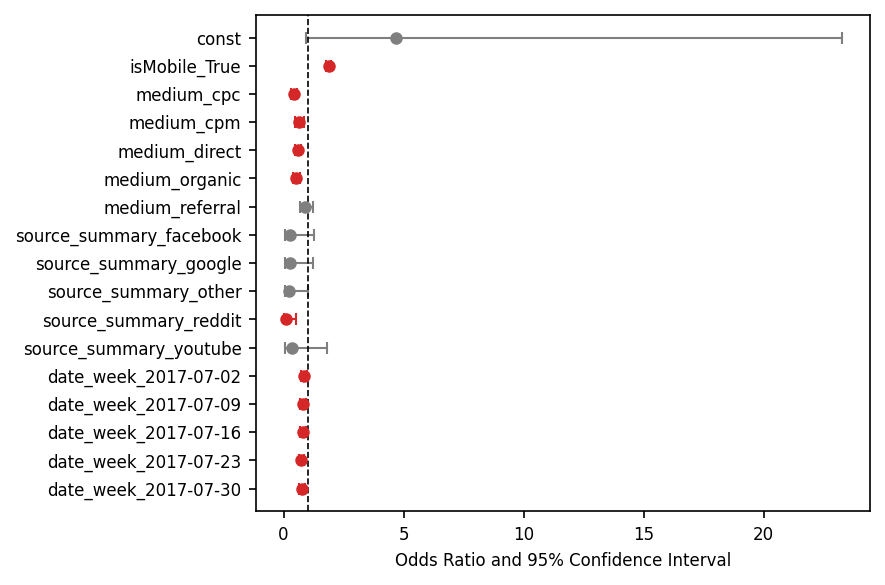

In [66]:
# Create forest plot to visulise the odds ratios
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in odds.iloc[::-1].iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant?'] == 'significant':
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                    markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                    markersize=5, mfc="tab:gray", mec="tab:gray")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
plt.savefig('forest_plot.png')
plt.show()